In [1]:
import datetime

import pandas as pd
import pandas_profiling as pdp
import numpy as np
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import optuna.integration.lightgbm as lgb_opt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 150)

In [2]:
# データロード
train_2018_df = pd.read_csv('../data/input/train_2018.csv')
train_2017_df = pd.read_csv('../data/input/train_2017.csv')
train_2016_df = pd.read_csv('../data/input/train_2016.csv')
train_2018_df['year'] = 2018
train_2017_df['year'] = 2017
train_2016_df['year'] = 2016

test_df = pd.read_csv('../data/input/test.csv')
test_df['year'] = 2019

In [3]:
# 教師データとテストデータのunion
all_df = pd.concat([train_2016_df, train_2017_df, train_2018_df, test_df], axis = 0).reset_index(drop=True)

### 特徴量エンジニアリング

In [4]:
# データ概要
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1902 non-null   int64  
 1   team                 1902 non-null   object 
 2   No                   1902 non-null   float64
 3   name                 1902 non-null   object 
 4   time_played          1414 non-null   float64
 5   position             1902 non-null   object 
 6   birthdate            1902 non-null   object 
 7   height               1902 non-null   float64
 8   weight               1902 non-null   float64
 9   salary               1902 non-null   object 
 10  nth_year             1902 non-null   float64
 11  is_youth             341 non-null    float64
 12  nationality          276 non-null    object 
 13  j1_total_num_played  1640 non-null   float64
 14  j1_total_scores      1554 non-null   float64
 15  j2_total_num_played  1134 non-null   f

In [5]:
# nationalityのNaN→Japan補完
all_df['nationality'] = all_df['nationality'].fillna('japan')

In [6]:
# team, name, position, nationalityのLabelEncoding
le = LabelEncoder()

for col in ['team', 'name', 'position', 'nationality']:
    le = le.fit(all_df[col])
    all_df[col] = le.transform(all_df[col])

In [7]:
# birthdateの年抽出
all_df['birthdate'] = pd.to_datetime(all_df['birthdate'])
all_df['birthdate_year'] = all_df['birthdate'].dt.year

In [8]:
# salaryのNaN→中央値補完
med_salary = all_df[all_df['salary'] != '-']['salary'].median()
all_df['salary'] = all_df['salary'].mask(all_df['salary'] == '-', med_salary)
all_df['salary'] = all_df['salary'].astype(float)

### 学習

In [9]:
# 教師, 検証データ
x_train_valid_df = all_df[all_df['year'] < 2019]
y_train_valid_df = x_train_valid_df['time_played']

# バリデーション
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid_df, y_train_valid_df, test_size=0.33, random_state=0)

# テストデータ
test = all_df[all_df['year'] == 2019]

In [10]:
# 入力する特徴量
features = [
    'team',
    'position',
    'height',
    'weight',
    'salary',
    'nth_year',
    'is_youth',
    'nationality',
    'birthdate_year',
    'year'
]

In [11]:
# カテゴリ変数
categorical_features = ['team', 'position', 'is_youth', 'nationality']

In [12]:
# lightgbmパラメータ
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_seed' : 0
}

In [13]:
# lightGBM用のデータセットを作成
lgb_train = lgb_opt.Dataset(x_train[features], y_train, categorical_feature = categorical_features, free_raw_data=False)
lgb_eval = lgb_opt.Dataset(x_valid[features], y_valid, categorical_feature = categorical_features, free_raw_data=False)

# モデルの作成
evals_result = {}
best_params = {}
model = lgb_opt.train(params = lgb_params,
                      train_set = lgb_train,
                      valid_sets = [lgb_train, lgb_eval],
                      categorical_feature = categorical_features,
                      verbose_eval = 10,
                      num_boost_round = 1000,
                      early_stopping_rounds = 10
)

# ベストパラメータの出力
best_params = model.params
print('=====Params======')
for key, value in best_params.items():
    print("  {}: {}".format(key, value))

# モデル精度の表示
valid_pred = model.predict(x_valid[features])
model_score = np.sqrt(metrics.mean_squared_error(valid_pred, y_valid))
print('=====Val score======')
print('  Val rmse score is {model_score}.'.format(model_score = model_score))

# テストデータの予測
y_pred = model.predict(test[features])

feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.449	valid_1's rmse: 915.758
[20]	training's rmse: 758.009	valid_1's rmse: 888.598
[30]	training's rmse: 693.526	valid_1's rmse: 870.034
[40]	training's rmse: 645.542	valid_1's rmse: 861.82
[50]	training's rmse: 607.796	valid_1's rmse: 859.847
[60]	training's rmse: 576.325	valid_1's rmse: 861.219
Early stopping, best iteration is:
[53]	training's rmse: 598.766	valid_1's rmse: 859.813


feature_fraction, val_score: 859.813101:  14%|######1                                    | 1/7 [00:00<00:00,  9.18it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 825.026	valid_1's rmse: 923.663
[20]	training's rmse: 733.471	valid_1's rmse: 885.945
[30]	training's rmse: 671.686	valid_1's rmse: 869.392
[40]	training's rmse: 622.608	valid_1's rmse: 867.795
Early stopping, best iteration is:
[39]	training's rmse: 627.543	valid_1's rmse: 866.752


feature_fraction, val_score: 859.813101:  29%|############2                              | 2/7 [00:00<00:00,  9.18it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 794.104	valid_1's rmse: 905.419
[20]	training's rmse: 702.282	valid_1's rmse: 872.12
[30]	training's rmse: 636.896	valid_1's rmse: 856.6
[40]	training's rmse: 587.662	valid_1's rmse: 858.586
Early stopping, best iteration is:
[30]	training's rmse: 636.896	valid_1's rmse: 856.6


feature_fraction, val_score: 856.600347:  43%|##################4                        | 3/7 [00:00<00:00,  9.93it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 850.462	valid_1's rmse: 939.437
[20]	training's rmse: 781.865	valid_1's rmse: 913.289
[30]	training's rmse: 721.664	valid_1's rmse: 897.717
[40]	training's rmse: 681.722	valid_1's rmse: 893.824
[50]	training's rmse: 645.828	valid_1's rmse: 889.786
[60]	training's rmse: 608.996	valid_1's rmse: 884.276
[70]	training's rmse: 578.833	valid_1's rmse: 881.971
[80]	training's rmse: 551.547	valid_1's rmse: 879.216
Early stopping, best iteration is:
[79]	training's rmse: 553.533	valid_1's rmse: 878.545


feature_fraction, val_score: 856.600347:  57%|########################5                  | 4/7 [00:00<00:00,  8.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 786.263	valid_1's rmse: 905.149
[20]	training's rmse: 687.943	valid_1's rmse: 870.706
[30]	training's rmse: 619.356	valid_1's rmse: 857.983
[40]	training's rmse: 568.904	valid_1's rmse: 859.241
[50]	training's rmse: 523.944	valid_1's rmse: 855.388
Early stopping, best iteration is:
[47]	training's rmse: 536.23	valid_1's rmse: 853.522


feature_fraction, val_score: 853.522095:  71%|##############################7            | 5/7 [00:00<00:00,  8.60it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 788.043	valid_1's rmse: 905.834
[20]	training's rmse: 689.003	valid_1's rmse: 872.737
[30]	training's rmse: 624.851	valid_1's rmse: 862.679
[40]	training's rmse: 573.547	valid_1's rmse: 859.665
Early stopping, best iteration is:
[36]	training's rmse: 591.882	valid_1's rmse: 857.59


feature_fraction, val_score: 853.522095:  86%|####################################8      | 6/7 [00:00<00:00,  8.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 806.71	valid_1's rmse: 900.656
[20]	training's rmse: 713.957	valid_1's rmse: 865.837
[30]	training's rmse: 647.886	valid_1's rmse: 851.566
[40]	training's rmse: 597.283	valid_1's rmse: 848.765
Early stopping, best iteration is:
[38]	training's rmse: 605.311	valid_1's rmse: 848.457


num_leaves, val_score: 848.456840:   0%|                                                        | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 848.456840:   5%|##4                                             | 1/20 [00:00<00:02,  7.20it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 835.279	valid_1's rmse: 911.429
[20]	training's rmse: 761.904	valid_1's rmse: 877.952
[30]	training's rmse: 709.675	valid_1's rmse: 864.502
[40]	training's rmse: 672.609	valid_1's rmse: 857.22
[50]	training's rmse: 641.564	valid_1's rmse: 853.758
[60]	training's rmse: 615.646	valid_1's rmse: 852.783
[70]	training's rmse: 588.953	valid_1's rmse: 850.162
[80]	training's rmse: 564.833	valid_1's rmse: 848.934
[90]	training's rmse: 546.081	valid_1's rmse: 850.587
Early stopping, best iteration is:
[82]	training's rmse: 561.498	valid_1's rmse: 848.506


num_leaves, val_score: 848.456840:  10%|####8                                           | 2/20 [00:00<00:02,  7.06it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 848.456840:  15%|#######2                                        | 3/20 [00:00<00:02,  6.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 841.078	valid_1's rmse: 911.091
[20]	training's rmse: 767.095	valid_1's rmse: 875.553
[30]	training's rmse: 718.819	valid_1's rmse: 856.301
[40]	training's rmse: 681.621	valid_1's rmse: 848.921
[50]	training's rmse: 655.097	valid_1's rmse: 847.645
Early stopping, best iteration is:
[46]	training's rmse: 665.739	valid_1's rmse: 846.53


num_leaves, val_score: 846.530432:  20%|#########6                                      | 4/20 [00:00<00:02,  6.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 904.128	valid_1's rmse: 942.868
[20]	training's rmse: 861.412	valid_1's rmse: 909.544
[30]	training's rmse: 833.668	valid_1's rmse: 890.902
[40]	training's rmse: 813.652	valid_1's rmse: 880.276
[50]	training's rmse: 794.738	valid_1's rmse: 872.734
[60]	training's rmse: 779.957	valid_1's rmse: 862.684
[70]	training's rmse: 767.652	valid_1's rmse: 861.952
[80]	training's rmse: 755.337	valid_1's rmse: 859.354
[90]	training's rmse: 745.851	valid_1's rmse: 856.48
[100]	training's rmse: 737.655	valid_1's rmse: 853.346
[110]	training's rmse: 730.702	valid_1's rmse: 852.246
Early stopping, best iteration is:
[109]	training's rmse: 731.643	valid_1's rmse: 851.965


num_leaves, val_score: 846.530432:  25%|############                                    | 5/20 [00:00<00:02,  7.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  30%|##############4                                 | 6/20 [00:00<00:01,  7.49it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  35%|################7                               | 7/20 [00:00<00:01,  7.35it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  40%|###################2                            | 8/20 [00:01<00:01,  7.24it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  45%|#####################6                          | 9/20 [00:01<00:01,  7.13it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  50%|#######################5                       | 10/20 [00:01<00:01,  5.76it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 931.306	valid_1's rmse: 957.361
[20]	training's rmse: 899.535	valid_1's rmse: 927.56
[30]	training's rmse: 882.787	valid_1's rmse: 912.917
[40]	training's rmse: 868.594	valid_1's rmse: 905.17
[50]	training's rmse: 856.189	valid_1's rmse: 901.632
[60]	training's rmse: 845.514	valid_1's rmse: 896.465
[70]	training's rmse: 835.669	valid_1's rmse: 893.971
[80]	training's rmse: 827.533	valid_1's rmse: 890.407
[90]	training's rmse: 820.686	valid_1's rmse: 886.294
[100]	training's rmse: 813.334	valid_1's rmse: 882.811
[110]	training's rmse: 807.307	valid_1's rmse: 879.607
[120]	training's rmse: 801.493	valid_1's rmse: 877.256
[130]	training's rmse: 796.203	valid_1's rmse: 875.735
[140]	training's rmse: 791.941	valid_1's rmse: 872.859
[150]	training's rmse: 787.05	valid_1's rmse: 872.842
Early stopping, best iteration is:
[141]	training's rmse: 791.5	valid_1's rmse: 871.783


num_leaves, val_score: 846.530432:  55%|#########################8                     | 11/20 [00:01<00:01,  6.56it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  60%|############################2                  | 12/20 [00:01<00:01,  6.78it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  65%|##############################5                | 13/20 [00:01<00:01,  6.99it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  70%|################################9              | 14/20 [00:01<00:00,  7.02it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 819.242	valid_1's rmse: 907.343
[20]	training's rmse: 736.888	valid_1's rmse: 874.156
[30]	training's rmse: 679.625	valid_1's rmse: 857.954
[40]	training's rmse: 637.147	valid_1's rmse: 854.625
Early stopping, best iteration is:
[38]	training's rmse: 645.005	valid_1's rmse: 853.226


num_leaves, val_score: 846.530432:  75%|###################################2           | 15/20 [00:02<00:00,  7.02it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 806.975	valid_1's rmse: 900.603
[20]	training's rmse: 716.842	valid_1's rmse: 866.862
[30]	training's rmse: 650.768	valid_1's rmse: 852.116
[40]	training's rmse: 602.447	valid_1's rmse: 852.466
Early stopping, best iteration is:
[31]	training's rmse: 646.017	valid_1's rmse: 851.794


num_leaves, val_score: 846.530432:  80%|#####################################6         | 16/20 [00:02<00:00,  8.17it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


num_leaves, val_score: 846.530432:  85%|#######################################9       | 17/20 [00:02<00:00,  7.89it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 947.762	valid_1's rmse: 967.844
[20]	training's rmse: 926.865	valid_1's rmse: 942.505
[30]	training's rmse: 915.424	valid_1's rmse: 931.072
[40]	training's rmse: 907.069	valid_1's rmse: 923.452
[50]	training's rmse: 900.402	valid_1's rmse: 916.345
[60]	training's rmse: 894.805	valid_1's rmse: 912.048
[70]	training's rmse: 889.964	valid_1's rmse: 908.29
[80]	training's rmse: 885.558	valid_1's rmse: 905.082
[90]	training's rmse: 881.638	valid_1's rmse: 904.87
[100]	training's rmse: 877.947	valid_1's rmse: 901.086
[110]	training's rmse: 874.611	valid_1's rmse: 899.189
[120]	training's rmse: 871.579	valid_1's rmse: 898.108
[130]	training's rmse: 868.729	valid_1's rmse: 896.709
[140]	training's rmse: 866.093	valid_1's rmse: 895.348
[150]	training's rmse: 863.672	valid_1's rmse: 893.804
[160]	training's rmse: 861.398	valid_1's rmse: 892.19
[170]	training's rmse: 859.266	valid_1's rmse: 891.3
[180]	training's r

num_leaves, val_score: 846.530432:  90%|##########################################3    | 18/20 [00:02<00:00,  7.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 806.71	valid_1's rmse: 900.656
[20]	training's rmse: 713.957	valid_1's rmse: 865.837
[30]	training's rmse: 647.886	valid_1's rmse: 851.566
[40]	training's rmse: 597.283	valid_1's rmse: 848.765
Early stopping, best iteration is:
[38]	training's rmse: 605.311	valid_1's rmse: 848.457


num_leaves, val_score: 846.530432:  95%|############################################6  | 19/20 [00:02<00:00,  7.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 803.659	valid_1's rmse: 905.813
[20]	training's rmse: 704.936	valid_1's rmse: 877.037
[30]	training's rmse: 639.786	valid_1's rmse: 863.379
[40]	training's rmse: 586.06	valid_1's rmse: 859.089
[50]	training's rmse: 545.874	valid_1's rmse: 858.775
[60]	training's rmse: 511.349	valid_1's rmse: 858.92
Early stopping, best iteration is:
[57]	training's rmse: 520.569	valid_1's rmse: 857.325


bagging, val_score: 846.530432:   0%|                                                           | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 877.433	valid_1's rmse: 918.402
[20]	training's rmse: 813.626	valid_1's rmse: 882.171
[30]	training's rmse: 773.591	valid_1's rmse: 878.034
Early stopping, best iteration is:
[24]	training's rmse: 795.794	valid_1's rmse: 875.42


bagging, val_score: 846.530432:  10%|#####1                                             | 1/10 [00:00<00:00, 15.88it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


bagging, val_score: 843.655669:  20%|##########2                                        | 2/10 [00:00<00:00, 13.17it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 839.764	valid_1's rmse: 910.375
[20]	training's rmse: 767.839	valid_1's rmse: 872.374
[30]	training's rmse: 717.901	valid_1's rmse: 860.365
[40]	training's rmse: 681.373	valid_1's rmse: 854.035
[50]	training's rmse: 651.775	valid_1's rmse: 855.068
[60]	training's rmse: 627.11	valid_1's rmse: 854.525
Early stopping, best iteration is:
[52]	training's rmse: 646.762	valid_1's rmse: 853.161


bagging, val_score: 843.655669:  30%|###############3                                   | 3/10 [00:00<00:00, 13.17it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.585	valid_1's rmse: 912.913
[20]	training's rmse: 765.949	valid_1's rmse: 873.983
[30]	training's rmse: 717.189	valid_1's rmse: 861.459
[40]	training's rmse: 682.427	valid_1's rmse: 853.604
Early stopping, best iteration is:
[38]	training's rmse: 688.936	valid_1's rmse: 852.286


bagging, val_score: 843.655669:  40%|####################4                              | 4/10 [00:00<00:00, 12.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 848.953	valid_1's rmse: 911.47
[20]	training's rmse: 776.225	valid_1's rmse: 872.543
[30]	training's rmse: 733.771	valid_1's rmse: 862.48
[40]	training's rmse: 698.31	valid_1's rmse: 859.354
[50]	training's rmse: 669.179	valid_1's rmse: 858.939
[60]	training's rmse: 642.601	valid_1's rmse: 855.954
[70]	training's rmse: 620.052	valid_1's rmse: 854.356
[80]	training's rmse: 599.279	valid_1's rmse: 853.098
[90]	training's rmse: 580.687	valid_1's rmse: 854.825
Early stopping, best iteration is:
[80]	training's rmse: 599.279	valid_1's rmse: 853.098


bagging, val_score: 843.655669:  50%|#########################5                         | 5/10 [00:00<00:00, 10.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 852.354	valid_1's rmse: 908.968
[20]	training's rmse: 775.766	valid_1's rmse: 872.921
[30]	training's rmse: 732.284	valid_1's rmse: 856.728
[40]	training's rmse: 694.991	valid_1's rmse: 856.451
Early stopping, best iteration is:
[39]	training's rmse: 697.41	valid_1's rmse: 854.772


bagging, val_score: 843.655669:  60%|##############################6                    | 6/10 [00:00<00:00, 10.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 877.957	valid_1's rmse: 919.364
[20]	training's rmse: 819.479	valid_1's rmse: 885.661
[30]	training's rmse: 786.007	valid_1's rmse: 873.629
[40]	training's rmse: 757.922	valid_1's rmse: 876.599
Early stopping, best iteration is:
[30]	training's rmse: 786.007	valid_1's rmse: 873.629


bagging, val_score: 843.655669:  70%|###################################6               | 7/10 [00:00<00:00, 11.51it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 843.707	valid_1's rmse: 914.042
[20]	training's rmse: 767.556	valid_1's rmse: 874.001
[30]	training's rmse: 721.583	valid_1's rmse: 867.748
[40]	training's rmse: 683.668	valid_1's rmse: 862.585
[50]	training's rmse: 656.211	valid_1's rmse: 858.518
[60]	training's rmse: 631.577	valid_1's rmse: 855.692
[70]	training's rmse: 606.912	valid_1's rmse: 856.993
Early stopping, best iteration is:
[60]	training's rmse: 631.577	valid_1's rmse: 855.692


bagging, val_score: 843.655669:  80%|########################################8          | 8/10 [00:00<00:00, 10.66it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 858.17	valid_1's rmse: 910.127
[20]	training's rmse: 790.095	valid_1's rmse: 875.498
[30]	training's rmse: 751.883	valid_1's rmse: 866.008
[40]	training's rmse: 718.82	valid_1's rmse: 863.48
[50]	training's rmse: 692.013	valid_1's rmse: 861.635
[60]	training's rmse: 669.929	valid_1's rmse: 857.535
[70]	training's rmse: 648.613	valid_1's rmse: 866.193
Early stopping, best iteration is:
[60]	training's rmse: 669.929	valid_1's rmse: 857.535


bagging, val_score: 843.655669:  90%|#############################################9     | 9/10 [00:00<00:00, 10.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 852.295	valid_1's rmse: 913.343
[20]	training's rmse: 778.082	valid_1's rmse: 874.111
[30]	training's rmse: 731.738	valid_1's rmse: 857.225
[40]	training's rmse: 697.005	valid_1's rmse: 851.15
Early stopping, best iteration is:
[38]	training's rmse: 703.183	valid_1's rmse: 850.33


feature_fraction_stage2, val_score: 843.655669:   0%|                                            | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


feature_fraction_stage2, val_score: 843.655669:  17%|######                              | 1/6 [00:00<00:00,  9.62it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


feature_fraction_stage2, val_score: 843.655669:  33%|############                        | 2/6 [00:00<00:00,  9.22it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


feature_fraction_stage2, val_score: 843.655669:  50%|##################                  | 3/6 [00:00<00:00,  9.06it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 851.521	valid_1's rmse: 924.308
[20]	training's rmse: 778.899	valid_1's rmse: 887.515
[30]	training's rmse: 730.79	valid_1's rmse: 863.677
[40]	training's rmse: 694.999	valid_1's rmse: 854.011
Early stopping, best iteration is:
[38]	training's rmse: 702.402	valid_1's rmse: 853.901


feature_fraction_stage2, val_score: 843.655669:  67%|########################            | 4/6 [00:00<00:00,  9.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


feature_fraction_stage2, val_score: 843.655669:  83%|##############################      | 5/6 [00:00<00:00,  9.32it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 830.133	valid_1's rmse: 907.463
[20]	training's rmse: 760.564	valid_1's rmse: 872.001
[30]	training's rmse: 711.716	valid_1's rmse: 857.664
[40]	training's rmse: 674.865	valid_1's rmse: 854.984
Early stopping, best iteration is:
[36]	training's rmse: 689.216	valid_1's rmse: 853.463


regularization_factors, val_score: 843.655669:   0%|                                            | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.165	valid_1's rmse: 909.131
[20]	training's rmse: 762.723	valid_1's rmse: 870.812
[30]	training's rmse: 713.844	valid_1's rmse: 852.996
[40]	training's rmse: 677.349	valid_1's rmse: 849.5
[50]	training's rmse: 646.445	valid_1's rmse: 845.79
[60]	training's rmse: 622.493	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.807	valid_1's rmse: 843.656


regularization_factors, val_score: 843.655669:   5%|#8                                  | 1/20 [00:00<00:02,  9.34it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 845.956	valid_1's rmse: 914.578
[20]	training's rmse: 774.389	valid_1's rmse: 878.788
[30]	training's rmse: 725.623	valid_1's rmse: 864.93
[40]	training's rmse: 690.49	valid_1's rmse: 862.013
[50]	training's rmse: 659.529	valid_1's rmse: 857.807
[60]	training's rmse: 635.41	valid_1's rmse: 854.985
[70]	training's rmse: 609.255	valid_1's rmse: 853.426
Early stopping, best iteration is:
[64]	training's rmse: 623.917	valid_1's rmse: 852.789


regularization_factors, val_score: 843.655669:  10%|###6                                | 2/20 [00:00<00:02,  8.64it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 849.917	valid_1's rmse: 915.934
[20]	training's rmse: 773.64	valid_1's rmse: 874.199
[30]	training's rmse: 728.496	valid_1's rmse: 861.336
[40]	training's rmse: 693.169	valid_1's rmse: 857.552
[50]	training's rmse: 663.482	valid_1's rmse: 855.71
Early stopping, best iteration is:
[45]	training's rmse: 677.485	valid_1's rmse: 854.856


regularization_factors, val_score: 843.655669:  15%|#####3                              | 3/20 [00:00<00:01,  8.66it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


regularization_factors, val_score: 843.655669:  20%|#######2                            | 4/20 [00:00<00:01,  8.36it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


regularization_factors, val_score: 843.655669:  25%|#########                           | 5/20 [00:00<00:01,  8.75it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.164	valid_1's rmse: 909.131
[20]	training's rmse: 762.722	valid_1's rmse: 870.812
[30]	training's rmse: 713.843	valid_1's rmse: 852.996
[40]	training's rmse: 677.348	valid_1's rmse: 849.499
[50]	training's rmse: 646.443	valid_1's rmse: 845.79
[60]	training's rmse: 622.491	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.804	valid_1's rmse: 843.656


regularization_factors, val_score: 843.655669:  30%|##########7                         | 6/20 [00:00<00:01,  8.99it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.165	valid_1's rmse: 909.131
[20]	training's rmse: 762.723	valid_1's rmse: 870.812
[30]	training's rmse: 713.844	valid_1's rmse: 852.996
[40]	training's rmse: 677.349	valid_1's rmse: 849.499
[50]	training's rmse: 646.444	valid_1's rmse: 845.79
[60]	training's rmse: 622.492	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.805	valid_1's rmse: 843.656


regularization_factors, val_score: 843.655643:  35%|############6                       | 7/20 [00:00<00:01,  9.10it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.167	valid_1's rmse: 909.132
[20]	training's rmse: 762.725	valid_1's rmse: 870.813
[30]	training's rmse: 713.846	valid_1's rmse: 852.997
[40]	training's rmse: 677.352	valid_1's rmse: 849.5
[50]	training's rmse: 646.448	valid_1's rmse: 845.79
[60]	training's rmse: 622.496	valid_1's rmse: 844.638
Early stopping, best iteration is:
[54]	training's rmse: 635.809	valid_1's rmse: 843.656


regularization_factors, val_score: 843.655569:  40%|##############4                     | 8/20 [00:00<00:01,  9.30it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.183	valid_1's rmse: 909.141
[20]	training's rmse: 762.743	valid_1's rmse: 870.818
[30]	training's rmse: 713.866	valid_1's rmse: 853
[40]	training's rmse: 677.374	valid_1's rmse: 849.501
[50]	training's rmse: 646.472	valid_1's rmse: 845.789
[60]	training's rmse: 622.521	valid_1's rmse: 844.636
Early stopping, best iteration is:
[54]	training's rmse: 635.834	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  45%|################2                   | 9/20 [00:01<00:01,  9.34it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.17	valid_1's rmse: 909.134
[20]	training's rmse: 762.728	valid_1's rmse: 870.814
[30]	training's rmse: 713.85	valid_1's rmse: 852.997
[40]	training's rmse: 677.355	valid_1's rmse: 849.5
[50]	training's rmse: 646.451	valid_1's rmse: 845.79
[60]	training's rmse: 622.5	valid_1's rmse: 844.637
Early stopping, best iteration is:
[54]	training's rmse: 635.813	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  50%|#################5                 | 10/20 [00:01<00:01,  9.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.174	valid_1's rmse: 909.136
[20]	training's rmse: 762.733	valid_1's rmse: 870.815
[30]	training's rmse: 713.855	valid_1's rmse: 852.998
[40]	training's rmse: 677.361	valid_1's rmse: 849.5
[50]	training's rmse: 646.458	valid_1's rmse: 845.789
[60]	training's rmse: 622.506	valid_1's rmse: 844.637
Early stopping, best iteration is:
[54]	training's rmse: 635.82	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  55%|###################2               | 11/20 [00:01<00:00,  9.53it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.175	valid_1's rmse: 909.137
[20]	training's rmse: 762.735	valid_1's rmse: 870.816
[30]	training's rmse: 713.857	valid_1's rmse: 852.998
[40]	training's rmse: 677.363	valid_1's rmse: 849.5
[50]	training's rmse: 646.46	valid_1's rmse: 845.789
[60]	training's rmse: 622.509	valid_1's rmse: 844.637
Early stopping, best iteration is:
[54]	training's rmse: 635.822	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  60%|#####################              | 12/20 [00:01<00:00,  9.50it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.172	valid_1's rmse: 909.135
[20]	training's rmse: 762.73	valid_1's rmse: 870.814
[30]	training's rmse: 713.852	valid_1's rmse: 852.997
[40]	training's rmse: 677.358	valid_1's rmse: 849.5
[50]	training's rmse: 646.455	valid_1's rmse: 845.79
[60]	training's rmse: 622.503	valid_1's rmse: 844.637
Early stopping, best iteration is:
[54]	training's rmse: 635.816	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  65%|######################7            | 13/20 [00:01<00:00,  9.59it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.178	valid_1's rmse: 909.138
[20]	training's rmse: 762.738	valid_1's rmse: 870.817
[30]	training's rmse: 713.86	valid_1's rmse: 852.999
[40]	training's rmse: 677.367	valid_1's rmse: 849.5
[50]	training's rmse: 646.465	valid_1's rmse: 845.789
[60]	training's rmse: 622.513	valid_1's rmse: 844.636
Early stopping, best iteration is:
[54]	training's rmse: 635.826	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  70%|########################5          | 14/20 [00:01<00:00,  9.10it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.179	valid_1's rmse: 909.138
[20]	training's rmse: 762.738	valid_1's rmse: 870.817
[30]	training's rmse: 713.861	valid_1's rmse: 852.999
[40]	training's rmse: 677.368	valid_1's rmse: 849.5
[50]	training's rmse: 646.465	valid_1's rmse: 845.789
[60]	training's rmse: 622.514	valid_1's rmse: 844.636
Early stopping, best iteration is:
[54]	training's rmse: 635.827	valid_1's rmse: 843.655


regularization_factors, val_score: 843.655029:  75%|##########################2        | 15/20 [00:01<00:00,  9.30it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.229	valid_1's rmse: 909.166
[20]	training's rmse: 762.796	valid_1's rmse: 870.834
[30]	training's rmse: 713.925	valid_1's rmse: 853.009
[40]	training's rmse: 677.153	valid_1's rmse: 849.69
[50]	training's rmse: 647.129	valid_1's rmse: 849.995
Early stopping, best iteration is:
[47]	training's rmse: 655.462	valid_1's rmse: 847.702


regularization_factors, val_score: 843.655029:  80%|############################       | 16/20 [00:01<00:00,  9.45it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.228	valid_1's rmse: 909.165
[20]	training's rmse: 762.794	valid_1's rmse: 870.834
[30]	training's rmse: 713.923	valid_1's rmse: 853.008
[40]	training's rmse: 677.15	valid_1's rmse: 849.69
[50]	training's rmse: 647.127	valid_1's rmse: 849.995
Early stopping, best iteration is:
[47]	training's rmse: 655.46	valid_1's rmse: 847.702


regularization_factors, val_score: 843.655029:  85%|#############################7     | 17/20 [00:01<00:00,  9.45it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.202	valid_1's rmse: 909.151
[20]	training's rmse: 762.765	valid_1's rmse: 870.825
[30]	training's rmse: 713.89	valid_1's rmse: 853.003
[40]	training's rmse: 677.4	valid_1's rmse: 849.502
[50]	training's rmse: 646.502	valid_1's rmse: 845.789
[60]	training's rmse: 622.551	valid_1's rmse: 844.634
Early stopping, best iteration is:
[54]	training's rmse: 635.864	valid_1's rmse: 843.654


regularization_factors, val_score: 843.654374:  90%|###############################5   | 18/20 [00:01<00:00,  9.69it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.198	valid_1's rmse: 909.149
[20]	training's rmse: 762.761	valid_1's rmse: 870.824
[30]	training's rmse: 713.886	valid_1's rmse: 853.003
[40]	training's rmse: 677.396	valid_1's rmse: 849.502
[50]	training's rmse: 646.496	valid_1's rmse: 845.789
[60]	training's rmse: 622.546	valid_1's rmse: 844.634
Early stopping, best iteration is:
[54]	training's rmse: 635.858	valid_1's rmse: 843.654


regularization_factors, val_score: 843.654374:  95%|#################################2 | 19/20 [00:02<00:00,  9.75it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 838.253	valid_1's rmse: 909.18
[20]	training's rmse: 762.824	valid_1's rmse: 870.842
[30]	training's rmse: 713.956	valid_1's rmse: 853.013
[40]	training's rmse: 677.186	valid_1's rmse: 849.691
[50]	training's rmse: 647.165	valid_1's rmse: 849.993
Early stopping, best iteration is:
[47]	training's rmse: 655.497	valid_1's rmse: 847.702


min_data_in_leaf, val_score: 843.654374:   0%|                                                   | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 829.335	valid_1's rmse: 915.16
[20]	training's rmse: 748.992	valid_1's rmse: 876.108
[30]	training's rmse: 692.978	valid_1's rmse: 858.887
[40]	training's rmse: 652.478	valid_1's rmse: 854.884
[50]	training's rmse: 615.548	valid_1's rmse: 856.207
Early stopping, best iteration is:
[40]	training's rmse: 652.478	valid_1's rmse: 854.884


min_data_in_leaf, val_score: 843.654374:  20%|########6                                  | 1/5 [00:00<00:00,  9.90it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 833.478	valid_1's rmse: 912.944
[20]	training's rmse: 755.281	valid_1's rmse: 872.606
[30]	training's rmse: 704.212	valid_1's rmse: 862.278
[40]	training's rmse: 662.129	valid_1's rmse: 862.007
Early stopping, best iteration is:
[38]	training's rmse: 668.337	valid_1's rmse: 861.339


min_data_in_leaf, val_score: 843.654374:  40%|#################2                         | 2/5 [00:00<00:00, 12.12it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 870.175	valid_1's rmse: 919.888
[20]	training's rmse: 809.548	valid_1's rmse: 880.285
[30]	training's rmse: 773.559	valid_1's rmse: 865.993
[40]	training's rmse: 745.814	valid_1's rmse: 861.253
[50]	training's rmse: 723.19	valid_1's rmse: 857.85
[60]	training's rmse: 703.847	valid_1's rmse: 858.911
Early stopping, best iteration is:
[51]	training's rmse: 721.047	valid_1's rmse: 856.431


min_data_in_leaf, val_score: 843.654374:  60%|#########################8                 | 3/5 [00:00<00:00, 12.12it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 841.915	valid_1's rmse: 909.642
[20]	training's rmse: 767.474	valid_1's rmse: 874.709
[30]	training's rmse: 720.388	valid_1's rmse: 863.887
[40]	training's rmse: 687.331	valid_1's rmse: 855.074
[50]	training's rmse: 657.081	valid_1's rmse: 851.425
[60]	training's rmse: 632.266	valid_1's rmse: 851.55
Early stopping, best iteration is:
[51]	training's rmse: 653.689	valid_1's rmse: 849.879


min_data_in_leaf, val_score: 843.654374:  80%|##################################4        | 4/5 [00:00<00:00, 11.84it/s]

Training until validation scores don't improve for 10 rounds
[10]	training's rmse: 899.07	valid_1's rmse: 936.306
[20]	training's rmse: 854.658	valid_1's rmse: 902.706
[30]	training's rmse: 825.538	valid_1's rmse: 883.204
[40]	training's rmse: 805.741	valid_1's rmse: 875.107
[50]	training's rmse: 789.641	valid_1's rmse: 868.75
[60]	training's rmse: 777.654	valid_1's rmse: 863.851
[70]	training's rmse: 764.88	valid_1's rmse: 863.997
[80]	training's rmse: 754.868	valid_1's rmse: 860.447
[90]	training's rmse: 746.903	valid_1's rmse: 858.654
Early stopping, best iteration is:
[84]	training's rmse: 751.794	valid_1's rmse: 857.206


min_data_in_leaf, val_score: 843.654374: 100%|###########################################| 5/5 [00:00<00:00, 10.94it/s]


=====Params======
  objective: regression
  metric: rmse
  random_seed: 0
  lambda_l1: 0.0003345077164843167
  lambda_l2: 0.01577389708323351
  num_leaves: 16
  feature_fraction: 0.7
  bagging_fraction: 0.962905450103474
  bagging_freq: 1
  min_child_samples: 20
=====Val score======
  Val rmse score is 843.6543741652541.


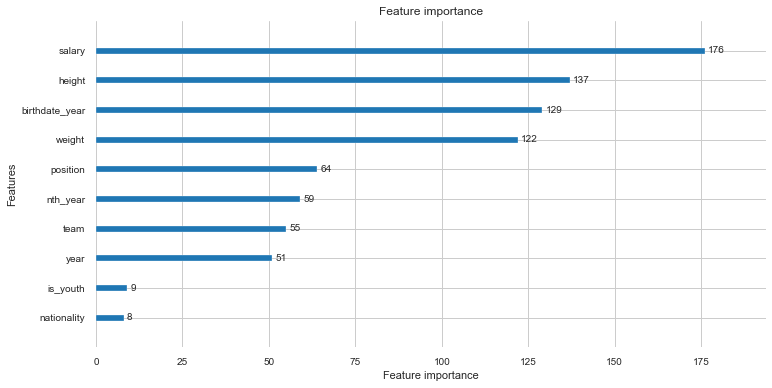

In [14]:
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

### 出力

In [15]:
# 提出用データの作成
sub = test[['id', 'time_played']].copy()
sub['time_played'] = y_pred

# csvの出力
now = datetime.datetime.now()
sub_name = 'optuna実装'
file_name = '../data/output/sub_' + sub_name + '_' + now.strftime('%Y%m%d_%H%M%S') + '.csv'
sub.to_csv(file_name, index=False)